In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st
import math as mth
import math
from scipy import stats

# Step 1. Open the data file and read the general information

In [2]:
data_log = pd.read_csv('data/logs_exp_us.csv',sep= '\t')

In [3]:
data_log.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data_log.dtypes

EventName         object
DeviceIDHash       int64
EventTimestamp     int64
ExpId              int64
dtype: object

In [6]:
data_log.shape

(244126, 4)

In [7]:
data_log.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 21.0 MB


# Step 2. Prepare the data for analysis

## 2.1 Rename the columns in a way that's convenient for you

In [8]:
data_log.columns = ['event', 'deviceID', 'dateTime', 'expID']
data_log.head(0)

,event,deviceID,dateTime,expID


## 2.2 Check for missing values and data types. Correct the data if needed

In [9]:
#Null data:
data_log.isna().sum()

event       0
deviceID    0
dateTime    0
expID       0
dtype: int64

In [10]:
#Duplicates:
data_log.duplicated().sum()

np.int64(413)

In [11]:
data_log = data_log.drop_duplicates()

In [12]:
#Dtypes:
for col in data_log:
    print (data_log[col].apply(type).head(1))

0    <class 'str'>
Name: event, dtype: object
0    <class 'int'>
Name: deviceID, dtype: object
0    <class 'int'>
Name: dateTime, dtype: object
0    <class 'int'>
Name: expID, dtype: object


## 2.3 Add a date and time column and a separate column for dates

In [13]:
data_log['dateTime'] = pd.to_datetime(data_log['dateTime'],unit='s')
data_log.head(2)

,event,deviceID,dateTime,expID
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [14]:
data_log['date'] = data_log['dateTime'].dt.date
data_log['date'] = pd.to_datetime(data_log['date'])
data_log.head(2)

,event,deviceID,dateTime,expID,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


# Step 3. Study and check the data

## 3.1 How many events are in the logs?

In [15]:
data_log.head()

,event,deviceID,dateTime,expID,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [16]:
data_log['event'].count()

np.int64(243713)

In [17]:
data_log['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

### Conclusion

There is 243713 events in total and 5 unique types of events:
1. MainScreenAppear
2. PaymentScreenSuccessful
3. CartScreenAppear
4. OffersScreenAppear
5. Tutorial

## 3.2 How many users are in the logs?

In [18]:
print('Amount of unique users in DF:',data_log['deviceID'].nunique())

Amount of unique users in DF: 7551


### Conclusion

There is 7551 unique user in DF.

## 3.3 What's the average number of events per user?

In [19]:
data_log.groupby('deviceID')['event'].count().reset_index().sort_values(by='event')

,deviceID,event
4387,5442802670051436393,1
11,19151588103329050,1
0,6888746892508752,1
3472,4336603908765108826,1
6448,7914773194539807942,1
...,...,...
1391,1754140665440434215,1221
5590,6932517045703054087,1439
3714,4623191541214045580,1768
147,197027893265565660,1998


In [20]:
average_event = ((data_log['deviceID'].nunique() / data_log['deviceID'].count())*100).round(2)
print('Average number of events per user:',average_event)

Average number of events per user: 3.1


### Conclusion

In average there is 3.1 event per unique user.

## 3.4 What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

In [21]:
data_log.head()

,event,deviceID,dateTime,expID,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [22]:
print('Date of the first event.:',data_log['date'].min())
print('Date of the last event.:',data_log['date'].max())

Date of the first event.: 2019-07-25 00:00:00
Date of the last event.: 2019-08-07 00:00:00


In [23]:
date_event_point = data_log.groupby('date')['event'].count().reset_index()
date_event_point.head()

,date,event
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184


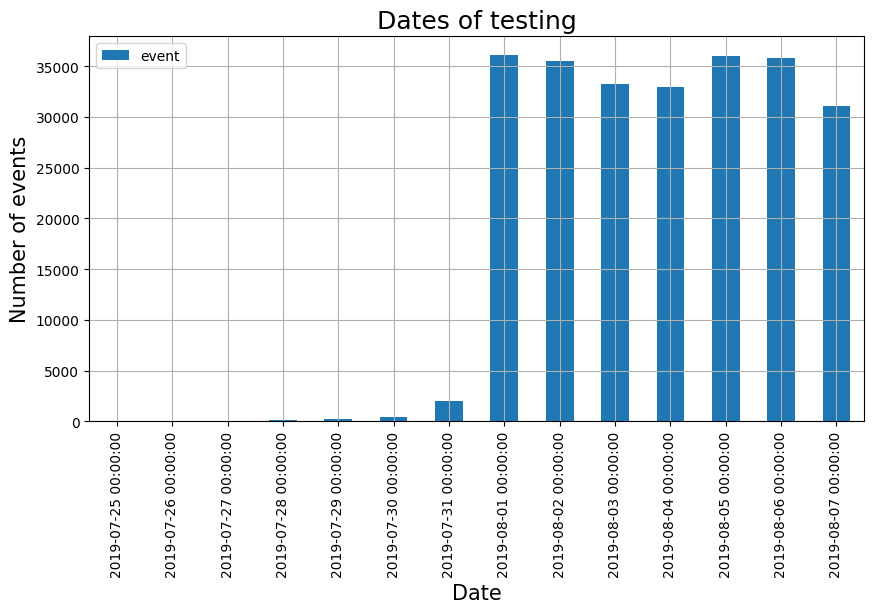

In [24]:
date_event_point.plot(x ='date', y='event',kind='bar', figsize=(10, 5),legend=True, grid=True)

plt.title('Dates of testing',fontsize=18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of events',fontsize=15)

plt.show()

### Conclusion

Starting from 2019-08-01 there is a sharp jump in the number of events.

This indicates that this particular date is the beginning of full-scale testing.
_______
Anything before this date is point technical tests.

## 3.5 Did you lose many events and users when excluding the older data?

In [25]:
data_log.head()

,event,deviceID,dateTime,expID,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [26]:
data_log_new = data_log[data_log['date'] >= '2019-08-01'].reset_index()
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [27]:
data_log_new['event'].count()

np.int64(240887)

In [28]:
data_log['event'].count()

np.int64(243713)

In [29]:
print('% of data lost:', (data_log['event'].count() / data_log_new['event'].count()).round(2))

% of data lost: 1.01


### Conclusion

A little more than 1% of data was lost, this loss is not significant, since previously defined, these data are technical tests and do not affect the analysis result.

## 3.6 Make sure you have users from all three experimental groups.

In [30]:
print('Number of unique experiments:',data_log_new['expID'].nunique())

Number of unique experiments: 3


In [31]:
data_log_new['expID'].value_counts().reset_index()

,expID,count
0,248,84563
1,246,79302
2,247,77022


### Conclusion

Each experimental group is presented in the DF.

# Step 4. Study the event funnel

## 4.1 See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [32]:
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [33]:
events_freq = data_log_new.groupby('event')['deviceID'].count().reset_index()
events_freq.columns = ['event','n_event']
events_freq

,event,n_event
0,CartScreenAppear,42303
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


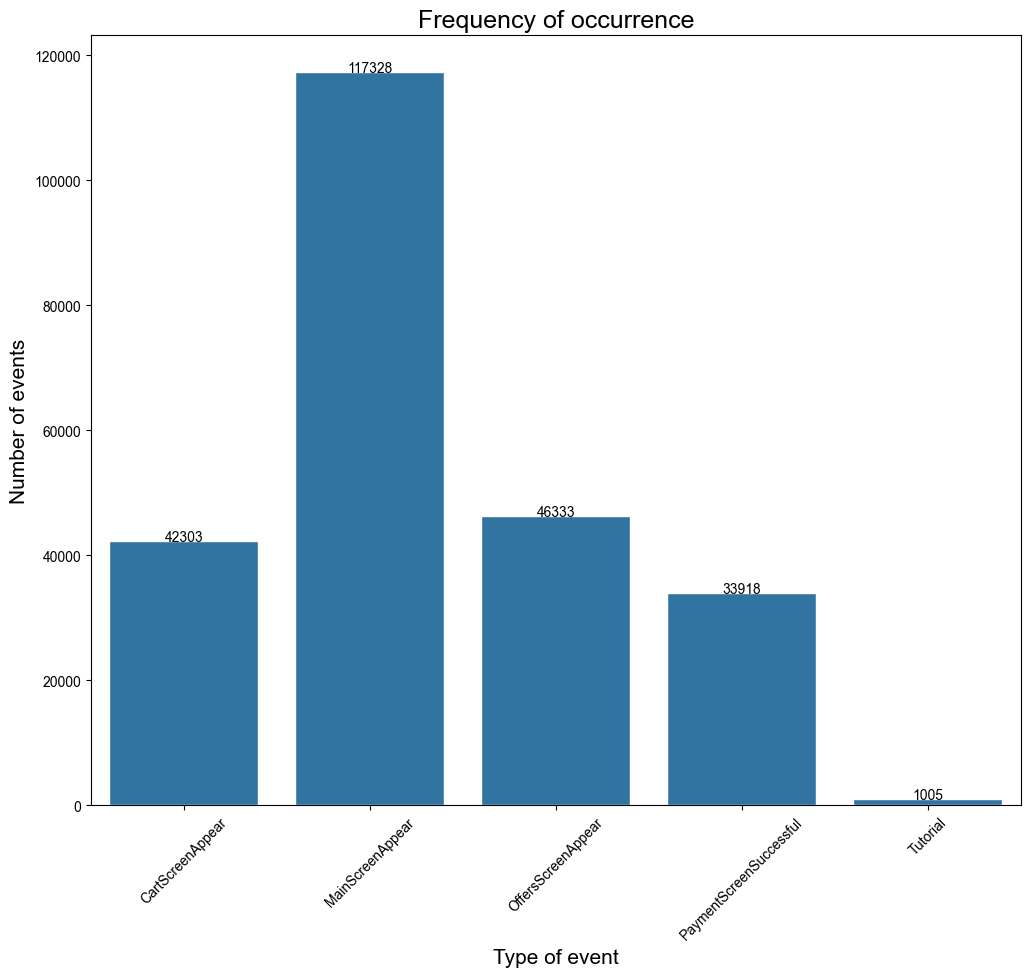

In [34]:
plt.figure(figsize=(12, 10))
plt.xticks(rotation=45)
sns.set_style("whitegrid")

ax = sns.barplot(x='event',y='n_event',data=events_freq)
ax.set_title('Frequency of occurrence', fontsize=18)
ax.set_ylabel('Number of events', fontsize=15)
ax.set_xlabel('Type of event', fontsize=15)

for index, row in events_freq.iterrows():
    ax.text(row.name,row.n_event, row.n_event, color='black', ha="center")
plt.show()

## Conclusion

As we can see, the most common evenе is 'MainScreenAppear' 117328 times.

At the same time, events 'OffersScreenAppear'(46333) and 'CartScreenAppear'(42303)are the second most frequent (with a slight increase to the side of 'OffersScreenAppear' event)

The event 'PaymentScreenSuccessful'(33918) is the third most frequent

The event 'Tutorial'(1005) is the least common
_____

Most of the users who saw the offer purchased it (80%)

While only 0.03 users used the tutorial, they bought the product.

## 4.2 Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

In [35]:
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [36]:
#Group by unique events and users:
user_events = data_log_new.groupby('deviceID').agg({'event': 'nunique'}).reset_index().sort_values(by='event',ascending=False)
user_events.head()

,deviceID,event
5718,7086945417901847497,5
6315,7766250438405005043,5
6996,8563831142507873525,5
6997,8565250933994196510,5
5880,7273808698005665705,5


#### Find the number of users who performed each of these actions

In [37]:
user_events_each = user_events[user_events['event'] == 5].reset_index()
print('Number of users who performed each action:',user_events_each['event'].count())

Number of users who performed each action: 466


#### Sort the events by the number of users.

In [38]:
events_user = data_log_new.groupby('event').agg({'deviceID': 'nunique'}).sort_values(by='deviceID',ascending=False).reset_index()
events_user.columns = ['event', 'n_events']
events_user.head()

,event,n_events
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


#### Calculate the proportion of users who performed the action at least once

In [39]:
user_events_1action = user_events[user_events['event'] == 1].reset_index()
print('Number of users who performed at least 1 action:',user_events_1action['event'].count())

Number of users who performed at least 1 action: 2717


In [40]:
unique_users = user_events['deviceID'].count()
print('Number of unique users:',unique_users)

Number of unique users: 7534


In [41]:
print('Proportion of users who performed at least 1 action:', (
    (user_events_1action['event'].count() / user_events['deviceID'].count())*100).round(2))

Proportion of users who performed at least 1 action: 36.06


### Conclusion

In total, we have 466 unique users who have at least 1 time for each event.
Number of unique users: 7534
______

2717 users have completed at least 1 event.

____

The ratio of users who completed at least 1 event to the total number of unique users: 36.06%


## 4.3 In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.

In [42]:
events_user.head()

,event,n_events
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


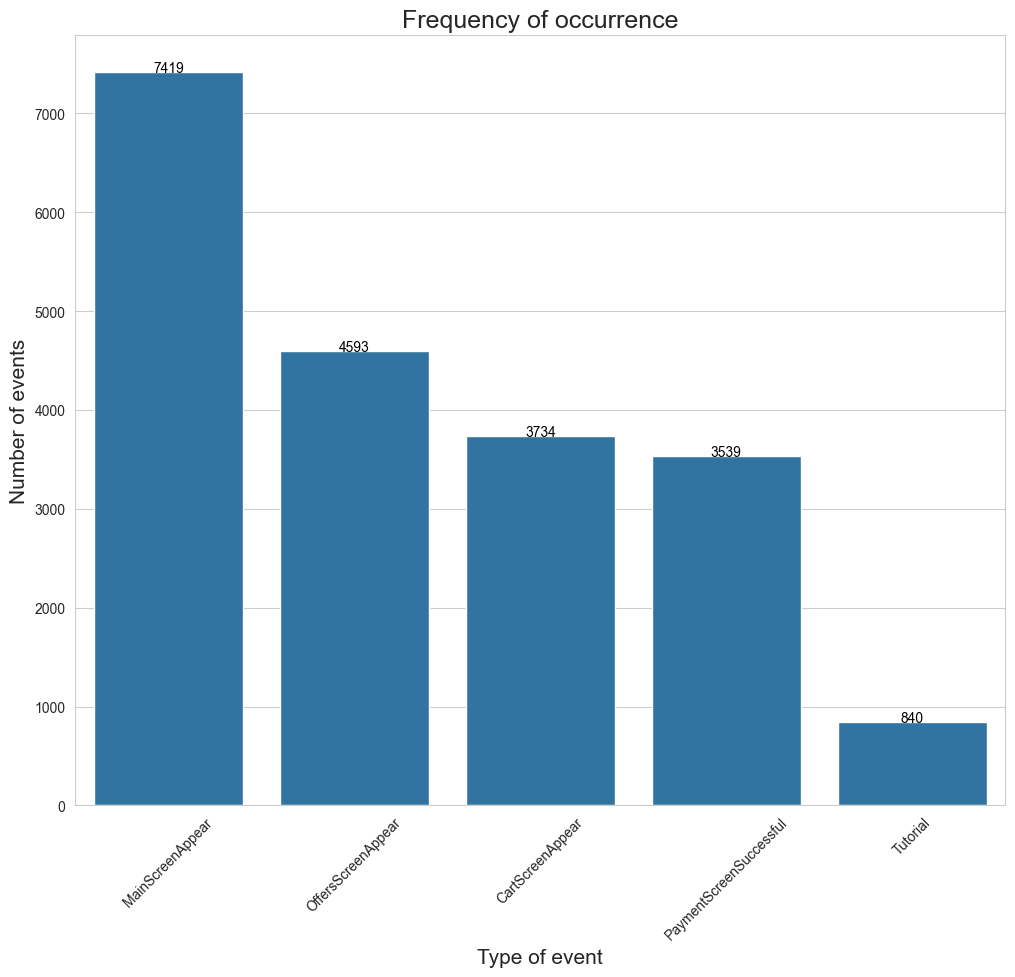

In [43]:
plt.figure(figsize=(12, 10))
plt.xticks(rotation=45)
sns.set_style("whitegrid")

ax = sns.barplot(x='event',y='n_events',data=events_user)
ax.set_title('Frequency of occurrence', fontsize=18)
ax.set_ylabel('Number of events', fontsize=15)
ax.set_xlabel('Type of event', fontsize=15)

for index, row in events_user.iterrows():
    ax.text(row.name,row.n_events, row.n_events, color='black', ha="center")
plt.show()

In [44]:
print('Number of unique users:',unique_users)

Number of unique users: 7534


# Conclusion

According to the graph above, a visual event funnel is emerging: MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful => Tutorial

______

The sequence doesn't have to be straight:

In the case of MainScreenAppear, the user could follow the referral link directly to the page with the offer and not have this event.

In the case of OffersScreenAppear, the user could get to it both through a referral link bypassing the main page, and through advertising on web sites.

In the case of CartScreenAppear, this event occurs only during the addition of a product, either via a link or from the main page, and is required to complete the purchase.

In the case of PaymentScreenSuccessful, this event occurs ONLY after CartScreenAppear.

In the case of the Tutorial, this event is optional and can occur both after PaymentScreenSuccessful and independently of the events (It can act as a kind of product advertisement without reference to the purchase)

## 4.4 Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

In [45]:
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [46]:
#Make a pivot table for funnel:
users = data_log_new.pivot_table(
    index='deviceID', 
    columns='event', 
    values='dateTime',
    aggfunc='min')
users.head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
deviceID,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


In [47]:
#Create steps:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

In [48]:
#Calculate funnel falues:
n_pageview = users[step_1].shape[0]
n_add_to_cart = users[step_2].shape[0]
n_checkout = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('MainScreen Appear:', n_pageview)
print('OffersScreen Appear:', n_add_to_cart)
print('CartScreen Appear:', n_checkout)
print('PaymentScreen Successful: ', n_payment, '\n')

print('Share of ppl who went to oferrsScreen:', ((n_add_to_cart / n_pageview)*100))
print('Share of ppl who went CartScreen:', ((n_checkout / n_pageview)*100))
print('Share of ppl who went PaymentScreen:', ((n_payment / n_pageview)*100))

MainScreen Appear: 7419
OffersScreen Appear: 4201
CartScreen Appear: 1767
PaymentScreen Successful:  454 

Share of ppl who went to oferrsScreen: 56.62488205957676
Share of ppl who went CartScreen: 23.81722604124545
Share of ppl who went PaymentScreen: 6.119423102844049


### Conclusion 

Less than 7% of visiters ended up paying for our service after going across the entire funnel.
_____
Share of ppl who went to oferrsScreen: 56.62

Share of ppl who went CartScreen: 23.81

Share of ppl who went PaymentScreen: 6.11


## 4.5 At what stage do you lose the most users?

In [49]:
print('Share of ppl who went to oferrsScreen:', ((n_add_to_cart / n_pageview)*100))

Share of ppl who went to oferrsScreen: 56.62488205957676


Most users leave at the transition from stage 'MainScreenAppear' to stage 'OffersScreen Appear'(43.38%)

## 4.6 What share of users make the entire journey from their first event to payment?

In [50]:
print('Share of ppl who went PaymentScreen:', ((n_payment / n_pageview)*100))

Share of ppl who went PaymentScreen: 6.119423102844049


Only 6.1% of all users who were in stage 1 completed a purchase by going through all 4 stages.

# Step 5. Study the results of the experiment

## 5.1 How many users are there in each group?

In [51]:
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [52]:
control_246=data_log_new[data_log_new.expID==246]['deviceID'].unique()
len(control_246)

2484

In [53]:
control_247=data_log_new[data_log_new.expID==247]['deviceID'].unique()
len(control_247)

2513

In [54]:
test=data_log_new[data_log_new.expID==248]['deviceID'].unique()
len(test)

2537

### Conclusion 

In [55]:
print('Test group have:', len(test), 'users')

Test group have: 2537 users


In [56]:
print('246 group have:',len(control_246), 'users')

246 group have: 2484 users


In [57]:
print('247 group have:',len(control_247), 'users')

247 group have: 2513 users


## 5.2  We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.

In [58]:
data_log_new.head()

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
1,2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2,2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
3,2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
4,2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [59]:
pivot = data_log_new.pivot_table(
    index='event', values='deviceID', columns='expID', aggfunc=lambda x: x.nunique()).reset_index()
pivot

expID,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


#### Hypothesis

H0 hypothesis: there is no significant difference between the proportions"

In [60]:
alpha = .05 # significance level

successes = np.array([1200, 1158])
trials = np.array([2484, 2513])

# success proportion in the first group:
p1 = successes[0]/trials[0]

# success proportion in the second group:
p2 = successes[1]/trials[1]

# success proportion in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference between the datasets' proportions
difference = p1 - p2
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)
# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

p-value:  0.11456679313141849
Failed to reject the null hypothesis: there is no reason to consider the proportions different


### Conclusion

There is no significant difference between the proportions

## 5.3 Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?

In [61]:
data_log_new.head(1)

,index,event,deviceID,dateTime,expID,date
0,2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01


In [62]:
pivot

expID,event,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [63]:
pivot['share_246'] = (pivot[246] / pivot[246].sum())*100
pivot['share_247'] = (pivot[247] / pivot[247].sum())*100
pivot['share_248'] = (pivot[248] / pivot[248].sum())*100
pivot

expID,event,246,247,248,share_246,share_247,share_248
0,CartScreenAppear,1266,1238,1230,18.794537,18.546816,18.319929
1,MainScreenAppear,2450,2476,2493,36.371734,37.093633,37.131367
2,OffersScreenAppear,1542,1520,1531,22.891924,22.771536,22.803098
3,PaymentScreenSuccessful,1200,1158,1181,17.814727,17.348315,17.590110
4,Tutorial,278,283,279,4.127078,4.239700,4.155496


#### Hypothesis

H0 hypothesis: there is no significant difference between the groups"

In [64]:
def check_hypothesis(group1,group2, event, alpha=0.05):
    # 
    successes1=pivot[pivot.event==event][group1].iloc[0]
    successes2=pivot[pivot.event==event][group2].iloc[0]
    
    #Trials 
    trials1=data_log_new[data_log_new.expID==group1]['deviceID'].nunique()
    trials2=data_log_new[data_log_new.expID==group2]['deviceID'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2)  

In [65]:
for i in pivot.event.unique():
    check_hypothesis(246,247, i, alpha=0.05)

p-value:  0.22883372237997213
Fail to Reject H0 for CartScreenAppear and groups 246 247
p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247
p-value:  0.2480954578522181
Fail to Reject H0 for OffersScreenAppear and groups 246 247
p-value:  0.11456679313141849
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247
p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247


#### Conclusion

For all events in test groups 246 and 247, we cannot reject the null hypothesis.

This means that there is a significant difference between the proportions of events in the groups.

## 5.4 Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

#### Hypothesis

H0 hypothesis: there is no significant difference between the groups"

In [66]:
for i in pivot.event.unique():
    check_hypothesis(246,248, i, alpha=0.05)

p-value:  0.07842923237520116
Fail to Reject H0 for CartScreenAppear and groups 246 248
p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248
p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248
p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248


In [67]:
for i in pivot.event.unique():
    check_hypothesis(247,248, i, alpha=0.05)

p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248
p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248
p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248
p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248
p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248


#### Conclusion
When comparing the test groups (246 and 247) with the control group (248), we cannot reject the null hypothesis

This means that there is a significant difference between the proportions of events.

## 5.5 What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

#### Hypothesis

H0 hypothesis: there is no significant difference between the groups"

In [68]:
for i in pivot.event.unique():
    check_hypothesis(246,248, i, alpha=0.1)

p-value:  0.07842923237520116
Reject H0 for CartScreenAppear and groups 246 248
p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248
p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248
p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248


In [69]:
for i in pivot.event.unique():
    check_hypothesis(247,248, i, alpha=0.1)

p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248
p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248
p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248
p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248
p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248


#### Conclusion

When the significance changed from 0.5 to 0.1, group 247 did not notice changes in the oblique null hypothesis.

In the case of group 246, when the significance changes from 0.5 to 0.1, there is a change in the case of the CartScreenAppear event: The null hypothesis is rejected. For the rest of the events of this group, no changes were recorded

# Final Conclusion

## When did it start?

Main testing starts on 2019-08-01.

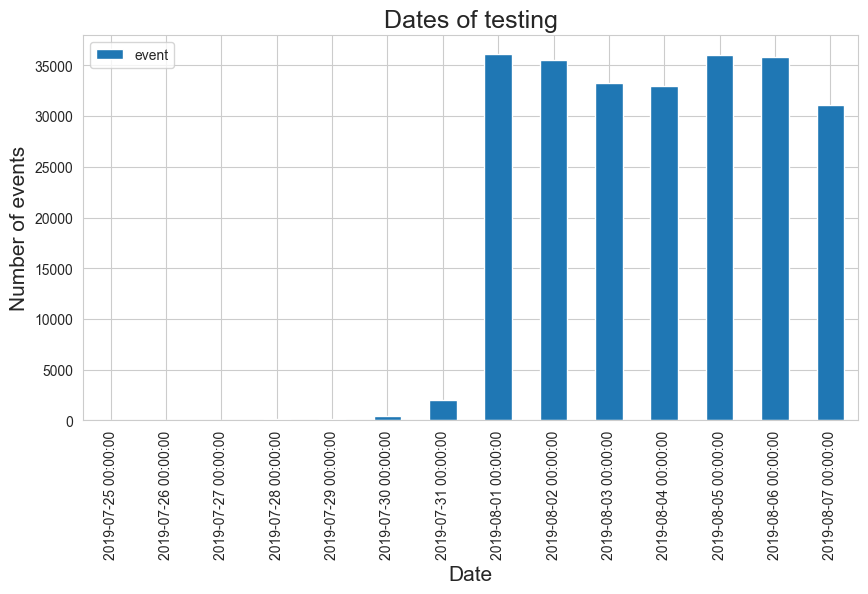

In [70]:
date_event_point.plot(x ='date', y='event',kind='bar', figsize=(10, 5),legend=True, grid=True)

plt.title('Dates of testing',fontsize=18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Number of events',fontsize=15)

plt.show()

## What event do users perform most often?

The most common type of event is 'MainScreenAppear'.

This type of event appears almost 2 times more often than the others, which indicates that users first of all go to the main page.

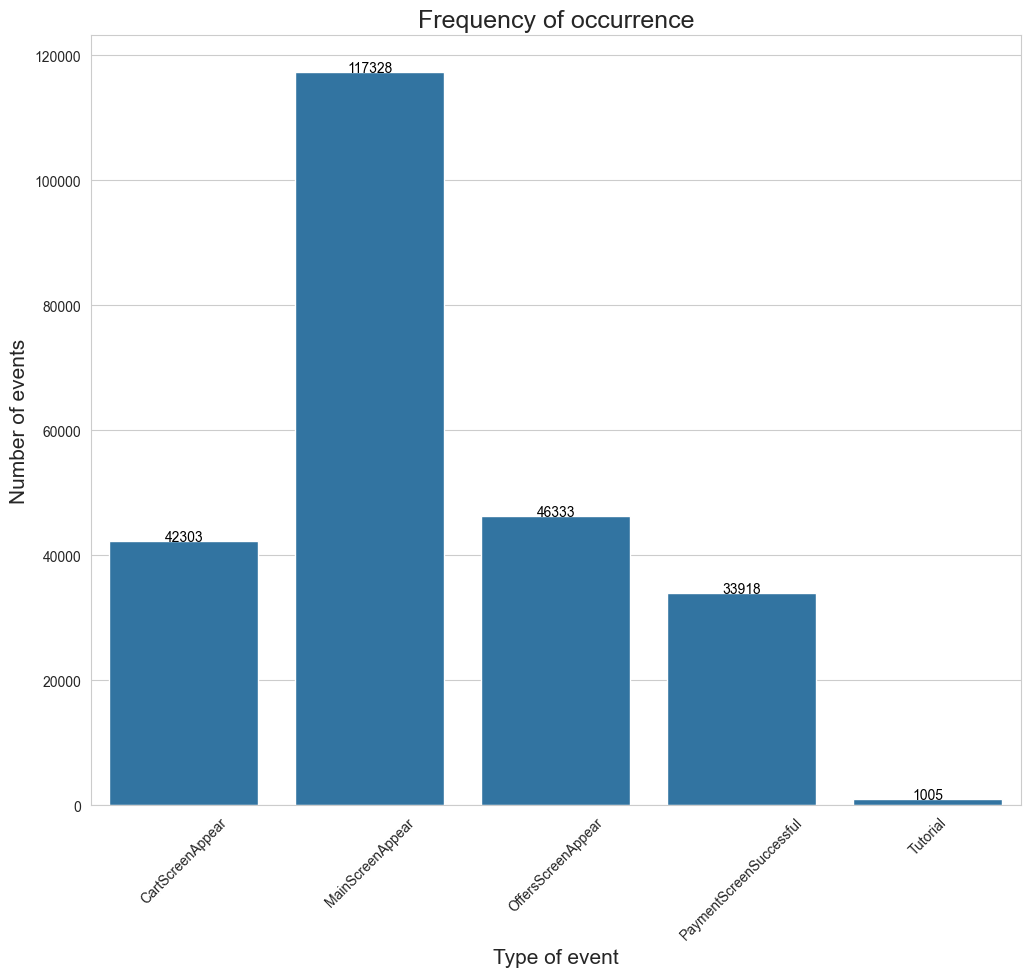

In [71]:
plt.figure(figsize=(12, 10))
plt.xticks(rotation=45)
sns.set_style("whitegrid")

ax = sns.barplot(x='event',y='n_event',data=events_freq)
ax.set_title('Frequency of occurrence', fontsize=18)
ax.set_ylabel('Number of events', fontsize=15)
ax.set_xlabel('Type of event', fontsize=15)

for index, row in events_freq.iterrows():
    ax.text(row.name,row.n_event, row.n_event, color='black', ha="center")
plt.show()

## User funnel

Only 454 out of 3539 buyers made a purchase after going through all the stages.

This may indicate that users tend to ignore a certain step and go straight to the cart and purchase.

In [72]:
print('Number of unique users:',unique_users)

Number of unique users: 7534


In [73]:
print('MainScreen Appear:', n_pageview)
print('OffersScreen Appear:', n_add_to_cart)
print('CartScreen Appear:', n_checkout)
print('PaymentScreen Successful: ', n_payment, '\n')

MainScreen Appear: 7419
OffersScreen Appear: 4201
CartScreen Appear: 1767
PaymentScreen Successful:  454 



## Testing hypotheses

When testing the hypothesis, there was no significant difference in purchases made between groups 246 and 247.

p-value:  0.11444799639438141

Failed to reject the null hypothesis: there is no reason to consider the proportions different
_____________

In the case of testing the proportions of events between groups 246 and 247, there was also no statistically significant difference.

In [74]:
for i in pivot.event.unique():
    check_hypothesis(246,247, i, alpha=0.05)

p-value:  0.22883372237997213
Fail to Reject H0 for CartScreenAppear and groups 246 247
p-value:  0.7570597232046099
Fail to Reject H0 for MainScreenAppear and groups 246 247
p-value:  0.2480954578522181
Fail to Reject H0 for OffersScreenAppear and groups 246 247
p-value:  0.11456679313141849
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247
p-value:  0.9376996189257114
Fail to Reject H0 for Tutorial and groups 246 247


____________________

In the case of testing the proportions of the events of the test groups (246 and 247) separately with the control group (248), there was also no statistically significant difference between the groups.

In [75]:
for i in pivot.event.unique():
    check_hypothesis(246,248, i, alpha=0.1)

p-value:  0.07842923237520116
Reject H0 for CartScreenAppear and groups 246 248
p-value:  0.2949721933554552
Fail to Reject H0 for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
Fail to Reject H0 for OffersScreenAppear and groups 246 248
p-value:  0.2122553275697796
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248
p-value:  0.8264294010087645
Fail to Reject H0 for Tutorial and groups 246 248


In [76]:
for i in pivot.event.unique():
    check_hypothesis(247,248, i, alpha=0.1)

p-value:  0.5786197879539783
Fail to Reject H0 for CartScreenAppear and groups 247 248
p-value:  0.4587053616621515
Fail to Reject H0 for MainScreenAppear and groups 247 248
p-value:  0.9197817830592261
Fail to Reject H0 for OffersScreenAppear and groups 247 248
p-value:  0.7373415053803964
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248
p-value:  0.765323922474501
Fail to Reject H0 for Tutorial and groups 247 248


The test results indicate that the data of the test and control groups were evenly distributed and the research results based on these groups can be applied to further planning the development of the organization.